# **CNN | Classification**

Now that we've extracted features from each audio file, we'll move on to the next crucial step: **classifying emotions using a Convolutional Neural Network** (CNN). Our model will learn to recognize patterns in the extracted features, allowing it to accurately distinguish between different emotional states present in the speech data.

## **Load packages**

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from keras.layers import Flatten, Dropout, Conv1D, MaxPooling1D, Dense

import tensorflow.keras.layers as L
from tensorflow.keras.models import load_model

## **Load dataset**

In [2]:
data = np.load('./features_npz/features.npz')

In [3]:
X = data['X']
labels = data['Y']

In [4]:
print(f"Size of features: {X.shape}")
print(f"Size of labels: {labels.shape}")

Size of features: (48648, 2376)
Size of labels: (48648,)


In [ ]:
np.unique(labels) # we've considered calm == neutral

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype='<U8')

## **Custom dataset**

In the `labels` array, we have words representing different emotions (e.g., "happy," "sad," "angry"). However, CNNs work with numerical data rather than raw text.  

To make our dataset compatible with the model, we need to transform these categorical labels into a numerical format. One common approach is **One-Hot Encoding**, which converts each label into a binary vector where only one position is `1` (representing the corresponding class), and all other positions are `0`. 

In [4]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(labels).reshape(-1,1)).toarray()

With all of this done, we are now ready to split the dataset into training and testing sets. We'll use **80% of the data for training** and **20% for testing** to ensure that our model learns effectively while still being evaluated on unseen data.

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42,test_size=0.2, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

The following code reshapes the training and testing data to be compatible with **CNN**:

In [6]:
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)

To improve the performance of our **CNN model**, we standardize the features using **StandardScaler**

In [7]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [8]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((38918, 2376), (38918, 7), (9730, 2376), (9730, 7))

## **CNN - Model**

### **Callbacks**

When training a **CNN model**, we use **callbacks** to optimize training and improve model performance. Two common callbacks are:

- **Model Checkpoint:** Prevents overfitting by keeping only the best model, and saves the best model weights based on accuracy.

- **ReduceLROnPlateau:** Helps avoid getting stuck in local minima by adjusting the learning rate dynamically.


In [ ]:
model_checkpoint = ModelCheckpoint('best_model1_weights.h5', monitor='val_accuracy', save_best_only=True)
lr_reduction=ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

CNNs expect **3D input data** in the format **(samples, features, channels)**. However, extracted features from audio are typically **2D** (samples, features), that's why we're going to add an extra channel dimension to our dataset.

In [9]:
x_train_cnn = np.expand_dims(x_train, axis=2)
x_test_cnn = np.expand_dims(x_test, axis=2)

x_train_cnn.shape, y_train.shape, x_test_cnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

### **Model implementation**

In [10]:
model = tf.keras.Sequential([
    Conv1D(256, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(7, activation='softmax') 
])

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

c:\Users\nayel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2374, 256)      │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1187, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1185, 128)      │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 592, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 590, 64)        │        24,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 295, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 293, 64)        │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 146, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 144, 32)        │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 72, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,503 (2.80 MB)

 Trainable params: 734,503 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
                    x_train_cnn, 
                    y_train, 
                    epochs=30, 
                    validation_data=(x_test_cnn, y_test), 
                    batch_size=64, 
                    callbacks=[lr_reduction,model_checkpoint]
                )

Epoch 1/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.3492 - loss: 1.5980

c:\Users\nayel\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\callbacks\callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


609/609 ━━━━━━━━━━━━━━━━━━━━ 405s 660ms/step - accuracy: 0.3493 - loss: 1.5977 - val_accuracy: 0.5121 - val_loss: 1.2316 - learning_rate: 0.0010
Epoch 2/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 578ms/step - accuracy: 0.5312 - loss: 1.1968

609/609 ━━━━━━━━━━━━━━━━━━━━ 381s 625ms/step - accuracy: 0.5312 - loss: 1.1967 - val_accuracy: 0.5754 - val_loss: 1.0703 - learning_rate: 0.0010
Epoch 3/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 559ms/step - accuracy: 0.5918 - loss: 1.0443

609/609 ━━━━━━━━━━━━━━━━━━━━ 368s 604ms/step - accuracy: 0.5918 - loss: 1.0443 - val_accuracy: 0.6231 - val_loss: 0.9643 - learning_rate: 0.0010
Epoch 4/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.6495 - loss: 0.9059

609/609 ━━━━━━━━━━━━━━━━━━━━ 371s 609ms/step - accuracy: 0.6495 - loss: 0.9059 - val_accuracy: 0.6596 - val_loss: 0.8779 - learning_rate: 0.0010
Epoch 5/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.6995 - loss: 0.7827

609/609 ━━━━━━━━━━━━━━━━━━━━ 373s 612ms/step - accuracy: 0.6995 - loss: 0.7827 - val_accuracy: 0.7150 - val_loss: 0.7597 - learning_rate: 0.0010
Epoch 6/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 561ms/step - accuracy: 0.7520 - loss: 0.6519

609/609 ━━━━━━━━━━━━━━━━━━━━ 370s 607ms/step - accuracy: 0.7520 - loss: 0.6519 - val_accuracy: 0.7487 - val_loss: 0.6970 - learning_rate: 0.0010
Epoch 7/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - accuracy: 0.8012 - loss: 0.5307

609/609 ━━━━━━━━━━━━━━━━━━━━ 368s 603ms/step - accuracy: 0.8012 - loss: 0.5307 - val_accuracy: 0.7912 - val_loss: 0.5701 - learning_rate: 0.0010
Epoch 8/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 544ms/step - accuracy: 0.8342 - loss: 0.4429

609/609 ━━━━━━━━━━━━━━━━━━━━ 357s 586ms/step - accuracy: 0.8342 - loss: 0.4429 - val_accuracy: 0.8033 - val_loss: 0.5454 - learning_rate: 0.0010
Epoch 9/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.8572 - loss: 0.3852

609/609 ━━━━━━━━━━━━━━━━━━━━ 403s 662ms/step - accuracy: 0.8572 - loss: 0.3852 - val_accuracy: 0.8305 - val_loss: 0.4761 - learning_rate: 0.0010
Epoch 10/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 865ms/step - accuracy: 0.8788 - loss: 0.3385

609/609 ━━━━━━━━━━━━━━━━━━━━ 572s 938ms/step - accuracy: 0.8788 - loss: 0.3385 - val_accuracy: 0.8629 - val_loss: 0.4040 - learning_rate: 0.0010
Epoch 11/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 873ms/step - accuracy: 0.8947 - loss: 0.2868

609/609 ━━━━━━━━━━━━━━━━━━━━ 574s 942ms/step - accuracy: 0.8947 - loss: 0.2868 - val_accuracy: 0.8777 - val_loss: 0.3664 - learning_rate: 0.0010
Epoch 12/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - accuracy: 0.9114 - loss: 0.2453

609/609 ━━━━━━━━━━━━━━━━━━━━ 578s 949ms/step - accuracy: 0.9114 - loss: 0.2453 - val_accuracy: 0.8853 - val_loss: 0.3457 - learning_rate: 0.0010
Epoch 13/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 652ms/step - accuracy: 0.9158 - loss: 0.2419

609/609 ━━━━━━━━━━━━━━━━━━━━ 429s 704ms/step - accuracy: 0.9158 - loss: 0.2419 - val_accuracy: 0.8886 - val_loss: 0.3459 - learning_rate: 0.0010
Epoch 14/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9264 - loss: 0.2064

609/609 ━━━━━━━━━━━━━━━━━━━━ 448s 736ms/step - accuracy: 0.9264 - loss: 0.2064 - val_accuracy: 0.8996 - val_loss: 0.3253 - learning_rate: 0.0010
Epoch 15/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 708ms/step - accuracy: 0.9315 - loss: 0.1902

609/609 ━━━━━━━━━━━━━━━━━━━━ 462s 759ms/step - accuracy: 0.9315 - loss: 0.1902 - val_accuracy: 0.9017 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 16/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9330 - loss: 0.1889

609/609 ━━━━━━━━━━━━━━━━━━━━ 424s 696ms/step - accuracy: 0.9330 - loss: 0.1888 - val_accuracy: 0.9074 - val_loss: 0.3106 - learning_rate: 0.0010
Epoch 17/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 549ms/step - accuracy: 0.9411 - loss: 0.1692

609/609 ━━━━━━━━━━━━━━━━━━━━ 362s 595ms/step - accuracy: 0.9411 - loss: 0.1692 - val_accuracy: 0.9138 - val_loss: 0.2926 - learning_rate: 0.0010
Epoch 18/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 526ms/step - accuracy: 0.9424 - loss: 0.1645

609/609 ━━━━━━━━━━━━━━━━━━━━ 346s 568ms/step - accuracy: 0.9424 - loss: 0.1645 - val_accuracy: 0.9141 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 19/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9392 - loss: 0.1780

609/609 ━━━━━━━━━━━━━━━━━━━━ 337s 554ms/step - accuracy: 0.9392 - loss: 0.1780 - val_accuracy: 0.9182 - val_loss: 0.2815 - learning_rate: 0.0010
Epoch 20/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 511ms/step - accuracy: 0.9512 - loss: 0.1440

609/609 ━━━━━━━━━━━━━━━━━━━━ 336s 552ms/step - accuracy: 0.9512 - loss: 0.1440 - val_accuracy: 0.9214 - val_loss: 0.2785 - learning_rate: 0.0010
Epoch 21/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9518 - loss: 0.1392

609/609 ━━━━━━━━━━━━━━━━━━━━ 336s 551ms/step - accuracy: 0.9517 - loss: 0.1392 - val_accuracy: 0.9234 - val_loss: 0.2751 - learning_rate: 0.0010
Epoch 22/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 339s 556ms/step - accuracy: 0.9545 - loss: 0.1287 - val_accuracy: 0.9220 - val_loss: 0.2964 - learning_rate: 0.0010
Epoch 23/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 339s 557ms/step - accuracy: 0.9554 - loss: 0.1305 - val_accuracy: 0.9201 - val_loss: 0.3067 - learning_rate: 0.0010
Epoch 24/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 516ms/step - accuracy: 0.9552 - loss: 0.1337

609/609 ━━━━━━━━━━━━━━━━━━━━ 340s 558ms/step - accuracy: 0.9552 - loss: 0.1337 - val_accuracy: 0.9261 - val_loss: 0.2640 - learning_rate: 0.0010
Epoch 25/30
608/609 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - accuracy: 0.9586 - loss: 0.1215

609/609 ━━━━━━━━━━━━━━━━━━━━ 338s 555ms/step - accuracy: 0.9586 - loss: 0.1214 - val_accuracy: 0.9288 - val_loss: 0.2600 - learning_rate: 0.0010
Epoch 26/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/step - accuracy: 0.9582 - loss: 0.1199

609/609 ━━━━━━━━━━━━━━━━━━━━ 336s 551ms/step - accuracy: 0.9582 - loss: 0.1199 - val_accuracy: 0.9299 - val_loss: 0.2698 - learning_rate: 0.0010
Epoch 27/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 340s 558ms/step - accuracy: 0.9617 - loss: 0.1065 - val_accuracy: 0.9211 - val_loss: 0.2916 - learning_rate: 0.0010
Epoch 28/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 381s 555ms/step - accuracy: 0.9620 - loss: 0.1128 - val_accuracy: 0.9263 - val_loss: 0.2582 - learning_rate: 0.0010
Epoch 29/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.9640 - loss: 0.1042

609/609 ━━━━━━━━━━━━━━━━━━━━ 338s 555ms/step - accuracy: 0.9640 - loss: 0.1042 - val_accuracy: 0.9307 - val_loss: 0.2511 - learning_rate: 0.0010
Epoch 30/30
609/609 ━━━━━━━━━━━━━━━━━━━━ 351s 576ms/step - accuracy: 0.9640 - loss: 0.1083 - val_accuracy: 0.9117 - val_loss: 0.3412 - learning_rate: 0.0010


We're going to plot how loss and accuracy have improved over the epochs

305/305 ━━━━━━━━━━━━━━━━━━━━ 31s 100ms/step - accuracy: 0.9306 - loss: 0.2444
Accuracy of our model on test data :  93.07296872138977 %


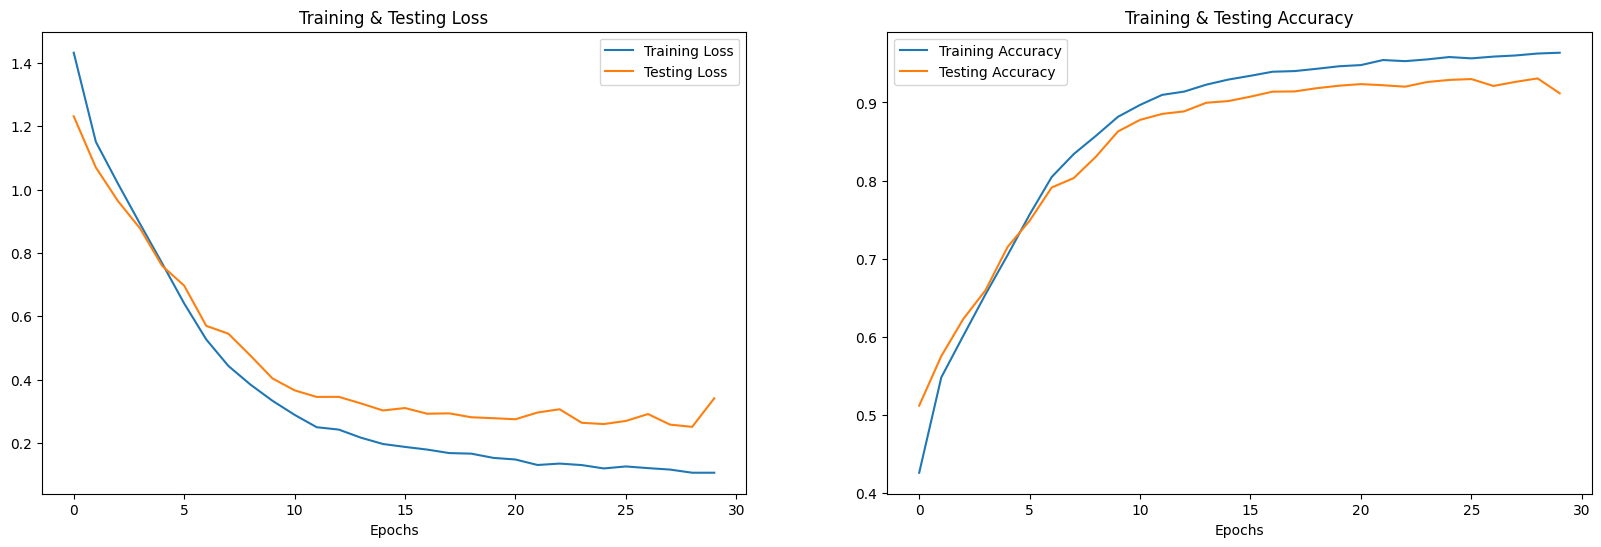

In [ ]:
print("Accuracy of our model on test data : " , model.evaluate(x_test_cnn,y_test)[1]*100 , "%")

epochs = [i for i in range(30)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

## **Metrics**

Now that we have trained the model, we will evaluate its performance by calculating some metrics.

- Accuracy
- Precision
- Recall
- F1 score

### **Load packages**

In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
import seaborn as sns

### **Load Model**

As we saved the best weights in a `.h5` file, we're going to load them into the model architecture.

In [12]:
hyperparams = 'best_model1_weights.h5'
model = load_model(hyperparams)

In [13]:
y_pred = model.predict(x_test_cnn)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 105ms/step


In [17]:
# F1-score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')  
print("F1-score:", f1)

# Accuracy
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy:", accuracy)

# Precision
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
print("Precision:", precision)

# Recall
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
print("Recall:", recall)


F1-score: 0.9307231356338388
Accuracy: 0.9307297019527235
Precision: 0.9309427916273181
Recall: 0.9307297019527235


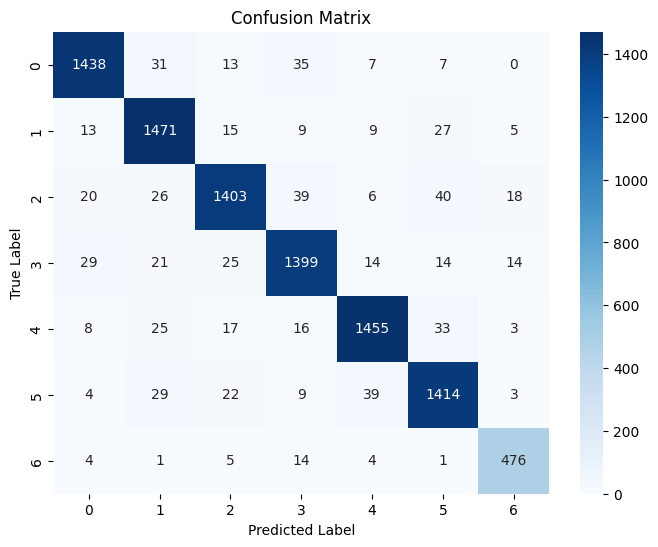

In [16]:
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

## **KFolds | Cross-validation**

In [75]:
import numpy as np
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import load_model

In [69]:
def build_model(input_shape):
    
    model = tf.keras.Sequential([
        
        Input(shape=input_shape),

        Conv1D(256, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),

        Conv1D(64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Conv1D(32, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.2),
        Dense(7, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [70]:
def cross_validate_cnn(X, Y, build_fn, k_folds=5, epochs=30, batch_size=32):
    
    """

        Aplica K-Fold Cross Validation a un modelo CNN en Keras.

        Params:
        - X: Datos de entrada (numpy array de forma (num_samples, timesteps, features))
        - Y: Etiquetas en formato one-hot encoding
        - build_fn: Función que devuelve un modelo Keras
        - k_folds: Número de particiones (default=5)
        - epochs: Número de épocas (default=10)
        - batch_size: Tamaño del batch (default=32)


    """

    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []


    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        
        print(f"\nTraining Fold {fold + 1}/{k_folds}...")

        X_train, X_val = X[train_idx], X[val_idx]
        Y_train, Y_val = Y[train_idx], Y[val_idx]

        model = build_fn(input_shape=(X_train.shape[1], 1))

        lrr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=0.00001, verbose=1)
        mc = ModelCheckpoint(f'./weights/weights_fold_{fold+1}.keras', monitor='val_accuracy', save_best_only=True)

        model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[lrr, mc])

        _, val_accuracy = model.evaluate(X_val, Y_val)

        print(f"Fold {fold + 1} | Accuracy: {val_accuracy:.4f}")

        fold_accuracies.append(val_accuracy)


    mean_accuracy = np.mean(fold_accuracies)
    print(f"\nMean Accuracy across {k_folds} folds: {mean_accuracy:.4f}")

    return fold_accuracies

In [71]:
x_train_cnn.shape, y_train.shape, x_test_cnn.shape, y_test.shape

((38918, 2376, 1), (38918, 7), (9730, 2376, 1), (9730, 7))

In [72]:
X_kf_small = x_train_cnn[:1000]
Y_small = y_train[:1000]
X_kf_small.shape, Y_small.shape

((1000, 2376, 1), (1000, 7))

In [ ]:
n_epochs = 3 # should be 30
kfolds = 5

In [74]:
accuracies = cross_validate_cnn(
                                X_kf_small, 
                                Y_small, 
                                build_model, 
                                k_folds=kfolds, 
                                epochs=n_epochs, 
                                batch_size=32
                            )


Training Fold 1/5...
Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 371ms/step - accuracy: 0.1589 - loss: 1.9453 - val_accuracy: 0.2050 - val_loss: 1.8973 - learning_rate: 0.0010
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 382ms/step - accuracy: 0.2531 - loss: 1.8394 - val_accuracy: 0.2550 - val_loss: 1.8489 - learning_rate: 0.0010
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 357ms/step - accuracy: 0.2673 - loss: 1.7920 - val_accuracy: 0.2750 - val_loss: 1.8407 - learning_rate: 0.0010
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - accuracy: 0.3007 - loss: 1.7796
Fold 1 | Accuracy: 0.2750

Training Fold 2/5...
Epoch 1/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step - accuracy: 0.1634 - loss: 1.9268 - val_accuracy: 0.2500 - val_loss: 1.8624 - learning_rate: 0.0010
Epoch 2/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.2238 - loss: 1.8858 - val_accuracy: 0.2250 - val_loss: 1.8398 - learning_rate: 0.0010
Epoch 3/3
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 407ms/step - accuracy: 0.2880 - loss: 1.8265 - val_accurac

In [ ]:
model_1 = load_model('./weights/weights_fold_1.keras')
model_2 = load_model('./weights/weights_fold_2.keras')
model_3 = load_model('./weights/weights_fold_3.keras')
model_4 = load_model('./weights/weights_fold_4.keras')
model_5 = load_model('./weights/weights_fold_5.keras')

In [80]:
def predict(model, x_test_cnn, idx=1):

    print(f"Predicting with model {idx}...")
    
    y_pred = model.predict(x_test_cnn)
    y_pred_labels = np.argmax(y_pred, axis=1)

    return y_pred_labels

In [81]:
y_pred_1 = predict(model_1, x_test_cnn, idx=1)
y_pred_2 = predict(model_2, x_test_cnn, idx=2)
y_pred_3 = predict(model_3, x_test_cnn, idx=3)
y_pred_4 = predict(model_4, x_test_cnn, idx=4)
y_pred_5 = predict(model_5, x_test_cnn, idx=5)

Predicting with model 1...
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 119ms/step
Predicting with model 2...
305/305 ━━━━━━━━━━━━━━━━━━━━ 37s 120ms/step
Predicting with model 3...
305/305 ━━━━━━━━━━━━━━━━━━━━ 35s 113ms/step
Predicting with model 4...
305/305 ━━━━━━━━━━━━━━━━━━━━ 38s 124ms/step
Predicting with model 5...
305/305 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step


In [88]:
def get_metrics(y_labels, y_pred, idx=1):

    f1 = f1_score(y_labels, y_pred, average='weighted')  
    accuracy = accuracy_score(y_labels, y_pred)
    precision = precision_score(y_labels, y_pred, average='weighted')
    recall = recall_score(y_labels, y_pred, average='weighted')
    cm = confusion_matrix(y_labels, y_pred)


    print(f"Metrics for model {idx}")
    print("F1-score:", f1)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)

    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(7), yticklabels=range(7))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    print("\n")

    #return f1, accuracy, precision, recall

Metrics for model 1
F1-score: 0.27564930113949576
Accuracy: 0.31099691675231245
Precision: 0.3379382623693433
Recall: 0.31099691675231245


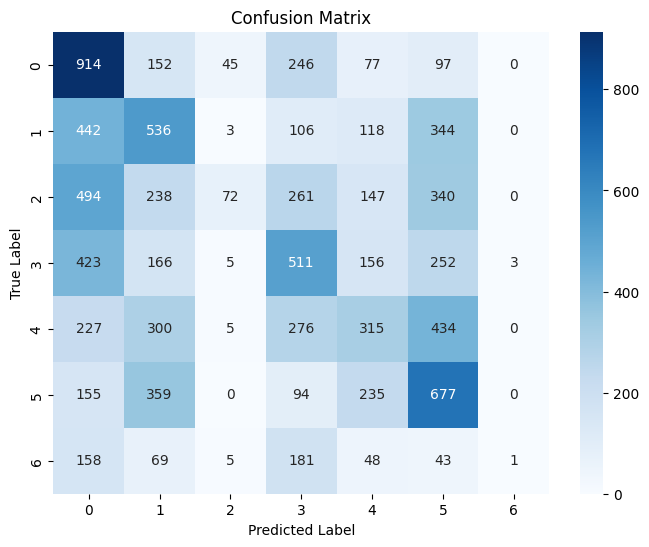



Metrics for model 2
F1-score: 0.14342056196698869
Accuracy: 0.22076053442959917
Precision: 0.1954062981376774
Recall: 0.22076053442959917


c:\Users\nayel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


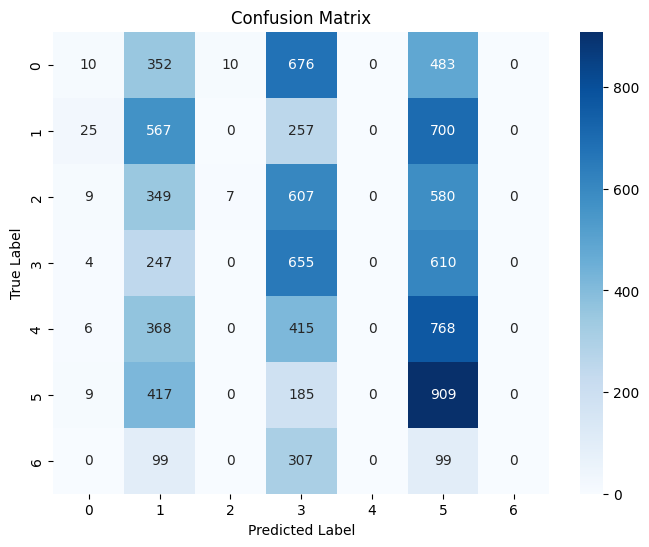



Metrics for model 3
F1-score: 0.1985170575661524
Accuracy: 0.2459403905447071
Precision: 0.29794855238899026
Recall: 0.2459403905447071


c:\Users\nayel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


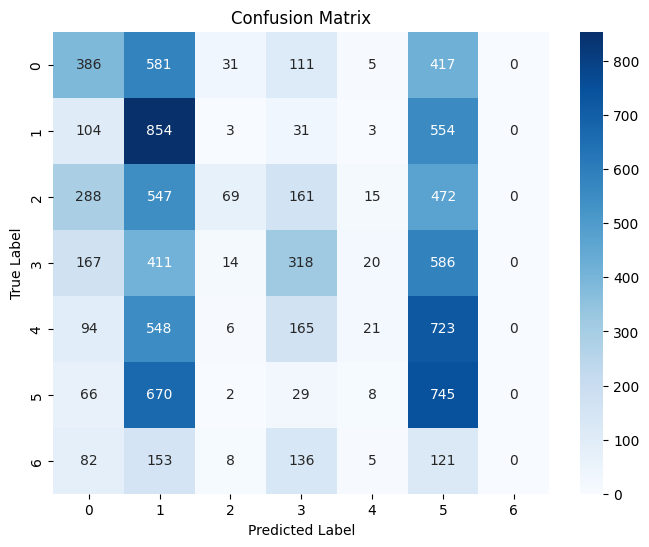



Metrics for model 4
F1-score: 0.24765130154225679
Accuracy: 0.2646454265159301
Precision: 0.27500627153931523
Recall: 0.2646454265159301


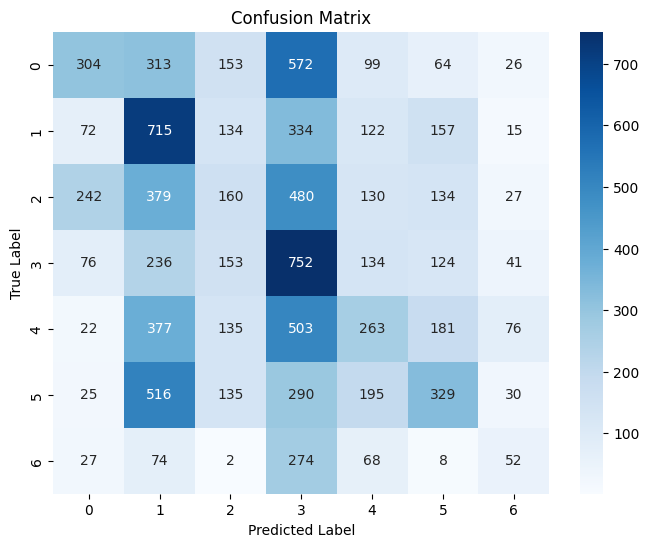



Metrics for model 5
F1-score: 0.24543252436382745
Accuracy: 0.2669064748201439
Precision: 0.29412866968091944
Recall: 0.2669064748201439


c:\Users\nayel\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


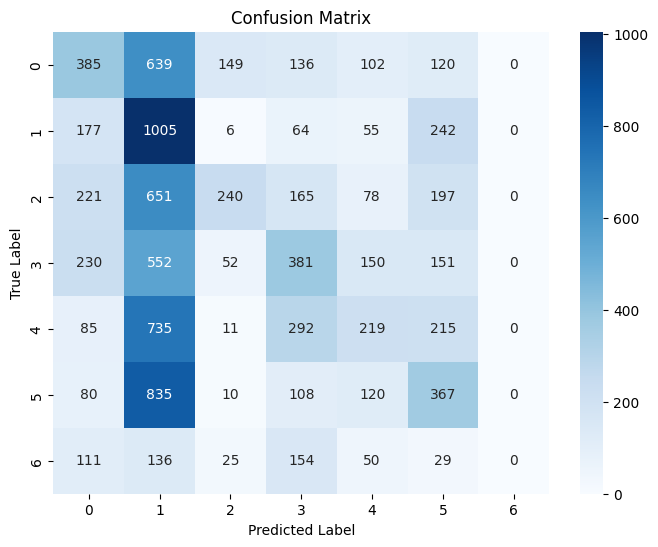

In [89]:
get_metrics(y_test_labels, y_pred_1, idx=1)
get_metrics(y_test_labels, y_pred_2, idx=2)
get_metrics(y_test_labels, y_pred_3, idx=3)
get_metrics(y_test_labels, y_pred_4, idx=4)
get_metrics(y_test_labels, y_pred_5, idx=5)
